# Tarefa 03 - Transfer Learning
Nesta tarefa você irá carregar a SqueezeNet com pesos treinados no ImageNet e fará a transferênicia de aprendizado para um problema de classificação de raças de cachorro. 

------------
## IMPORTANTE
##### Verifique os pontos abaixo antes de começar a tarefa:
- Faça download do dataset (arquivo `INF0618_Tarefa03_dogDataset.zip`) em `https://goo.gl/r44kAQ` e descomprima o .zip no mesmo diretório deste notebook;
- Verifique se, após descomprimir .zip, há uma pasta `INF0618_Tarefa03_dogDataset` com as subpastas `train`, `test`, `val`;
- Faça o download do modelo da squeezeNet (arquivo `squeezenet_weights_tf_dim_ordering_tf_kernels.h5` disponível no Moodle). Você também pode copiar o modelo dos arquivos da Aula 04 (apenas verifique o nome do arquivo).
- Não há necessidade de alterar os códigos das sessões `Imports`, `Definição da SqueezeNet` e `Dataset`.
-----------


As tarefas são:

**1) Definição do modelo [0.25 pts]**
- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.

**2) Treinamento [0.25 pts]**
- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;

**3) Teste [0.25 pts]**
- Avalie o conjunto de teste e reporte a loss e a acurácia normalizada;

**4) Conclusões [0.25 pts]**
- Escreva um parágrafo resumindo o que você fez, as dificuldades que encontrou, o que deu certo/errado e as suas conclusões desta atividade.

------

## Imports

In [14]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.layers.core import Flatten, Dense
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

## Definição do modelo base da SqueezeNet
As funções abaixo criam o modelo da SqueezeNet e carregam os seus pesos treinados no ImageNet.

In [15]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

# Dataset
O dataset é composto por 83 classes (raças de cachorro) com 100 imagens de treinamento por classe. No conjunto de validação, há 73 imagens por classe. As imagens estão nomeadas no formato `xx_yyyy.jpg`, onde `xx` denota a classe (de 00 até 82) e `yyyy` é apenas um identificador da imagem.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [16]:
datasetDir = "./INF0618_Tarefa03_dogDataset"
nbClasses = 83

def getDatasetSize(split='train'):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]
    return len(fileNames)

#Read our dataset in batches
def loadDatasetInBatches(split="train", batch_size=32):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]

    while True:
        shuffledFileNames = sample(fileNames, len(fileNames)) #shuffle images in each epoch
        imagePaths = [os.path.join(splitDir,img) for img in shuffledFileNames] #get image paths
        
        batch, labelList = [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(imagePaths))):
                        img = img_to_array(load_img(imagePaths[idx], target_size=(227, 227)))
                        img = img.astype('float32')
                        img /= 255.0
                    
                        label = np_utils.to_categorical(getLabelFromImgName(shuffledFileNames[idx], split), nbClasses)
                        
                        ######### If you want to run with Data Augmentation, just uncomment here
                        ##### you can add more transformations (see https://keras.io/preprocessing/image/)
                        ### We apply a random transformation and add this image (instead of the original)
                        ### to the batch...
                        
                        #dataAugmentator = ImageDataGenerator(horizontal_flip = True)
                        #img = dataAugmentator.random_transform(img)
                        
                        
                        batch.append(img)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield np.array(batch), np.array(labelList)
                            batch, labelList = [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield np.array(batch), np.array(labelList)


def getLabelFromImgName(imgName, split):
    return int(imgName.split("_")[0])
        
    
#plot the images from imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
               
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize("train")
valSetSize = getDatasetSize("val")
testSetSize = getDatasetSize("test")

print("# images in Train set: ", trainSetSize)
print("# images in Val set: ", valSetSize)
print("# images in Test set: ", testSetSize)

# images in Train set:  8300
# images in Val set:  260
# images in Test set:  5420


(5, 227, 227, 3) (5, 83)


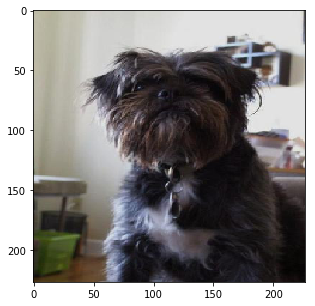

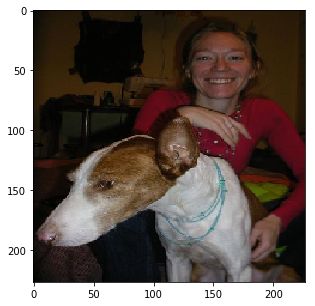

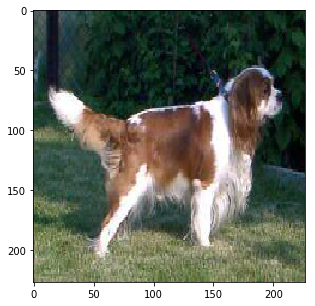

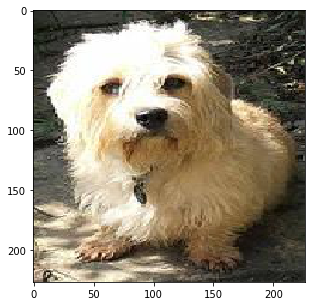

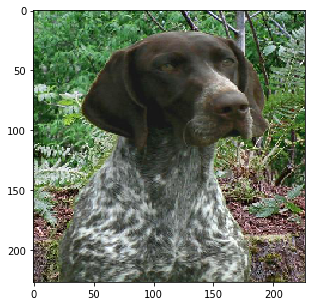

In [17]:
for batch, labels in loadDatasetInBatches(split='train', batch_size=5):
    print(batch.shape, labels.shape)
    plotImages(batch)
    break

### Como o load do dados é feito...  
O método que iremos utilizar para ler os dados é o `loadDatasetInBatches(split='train', batch_size=32)`. Ele é um generator (semelhante ao método que fazia a aumentação de dados na Aula 03), ou seja, ele gera um fluxo de batches e labels a partir do nosso dataset.

**Argumentos**:
- (string) **split**: pode ser `'train'`, `'val'` ou `'test'`. Se refere a qual conjunto de dados que iremos ler (treino, validação ou teste);
- (int) **batch_size**: quantas imagens por batch;

**Retorno**: 
- **batch**: retorna um array do numpy com as imagens carregadas e pre-processadas. **batch** tem dimensões (batch_size, 227, 227, 3), pois as imagens tem tamanho 227x227 e tem 3 canais (RGB);
- **labels**: retorna um array do numpy com as labels já transformadas em one_hot_encode (array de 83 dimensões, com 1 na posição do índice da classe e 0 nas outras posições). **batch** tem dimensões (batch_size, 83);
    
Utilizando o argumento `split`, o método lê os nomes das imagens do diretório correto e as embaralha (para garantir que a cada época os batches sejam diferentes). Para cada época (um loop do `for` interno), o método irá carregar uma imagem por vez e irá gerar a sua label (obtendo a classe pelo próprio nome da imagem). Esta imagem/label será colocada em listas **batch/labelList**.

Quando estas listas estiverem com **batch_size** elementos, teremos gerado um batch. O método dá um yield nessas duas e recomeça a construção de um novo batch. Quando o `for` terminar, iremos ter completado uma época. O `while True` apenas garante uma nova época seja iniciada. Quem controlará o fim do `while` vai ser o método que fará o fit, portanto não precisamos nos preocupar com isso.  

-----------
-----------
-----------
** -----> A tarefa começa aqui !!! Vocês não precisam modificar nada dos códigos acima!** 

# Definição do modelo [0.25 pts]

- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.
    - Lembrem-se que ao final da rede, precisamos de camadas de classificação:
        - Conv2D + GlobalAveragePooling + SoftMax (aula 05)
        - Flatten + Dense + SoftMax (aulas anteriores)
    - Se acharem necessário, podem também adicionar outras camadas (Dropout, Conv2D, módulos Fire);
    
    
**Não se esqueçam de:**
- Definir novas camadas da mesma forma que fizemos na Aula 05 (utilizando o x = ...(x))
- Ao final da célula, definir o modelo novo com o input da squeeze base e o output da última camada adicionada

In [18]:
# Definir o modelo base da squeezeNet 
squeezeNetModel = SqueezeNet((227,227,3))

# Escolher a camada que será o ponto de partida 
x = squeezeNetModel.get_layer(name='fire9/concat').output

# Congelar (ou não) camadas
print([layer.name for layer in squeezeNetModel.layers])
print("\n\nFreeze layers up until ", squeezeNetModel.layers[-20].name)
for layer in squeezeNetModel.layers[:-20]:
    layer.trainable = False

# Adicionar novas camadas
#x = Convolution2D(nbClasses, (1,1), padding='valid', name='conv10_new')(x)
#x = Activation('relu', name='relu_conv10_new')(x)
#x = GlobalAveragePooling2D()(x)
#x = Activation('softmax', name='loss_new')(x)
x = Dense(830, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5, name='drop9')(x)
x = Convolution2D(nbClasses, (1,1), padding='valid', name='conv10_new')(x)
x = Activation('relu', name='relu_conv10_new')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss_new')(x)




# Não se esqueça de definir o nome modelo, onde baseSqueezeNetModel 
# é o modelo base da Squeeze que vc definiu ali em cima
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

['input_5', 'conv1', 'relu_conv1', 'pool1', 'fire2/squeeze1x1', 'fire2/relu_squeeze1x1', 'fire2/expand1x1', 'fire2/expand3x3', 'fire2/relu_expand1x1', 'fire2/relu_expand3x3', 'fire2/concat', 'fire3/squeeze1x1', 'fire3/relu_squeeze1x1', 'fire3/expand1x1', 'fire3/expand3x3', 'fire3/relu_expand1x1', 'fire3/relu_expand3x3', 'fire3/concat', 'pool3', 'fire4/squeeze1x1', 'fire4/relu_squeeze1x1', 'fire4/expand1x1', 'fire4/expand3x3', 'fire4/relu_expand1x1', 'fire4/relu_expand3x3', 'fire4/concat', 'fire5/squeeze1x1', 'fire5/relu_squeeze1x1', 'fire5/expand1x1', 'fire5/expand3x3', 'fire5/relu_expand1x1', 'fire5/relu_expand3x3', 'fire5/concat', 'pool5', 'fire6/squeeze1x1', 'fire6/relu_squeeze1x1', 'fire6/expand1x1', 'fire6/expand3x3', 'fire6/relu_expand1x1', 'fire6/relu_expand3x3', 'fire6/concat', 'fire7/squeeze1x1', 'fire7/relu_squeeze1x1', 'fire7/expand1x1', 'fire7/expand3x3', 'fire7/relu_expand1x1', 'fire7/relu_expand3x3', 'fire7/concat', 'fire8/squeeze1x1', 'fire8/relu_squeeze1x1', 'fire8/expa

# Treinamento [0.25 pts]

- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;


No treinamento iremos utilizar o `fit_generator` (mesmo utilizado no Aula03 com Data Augmentation). Ele recebe um generator (que será fornecido pelo `loadDatasetInBatches`). Como o generator retorna um fluxo de batches/labels, o `fit_generator` não tem informação sobre o tamanho dataset. Por isso, precisamos informar o número de épocas (parâmetro `epochs`) e também quantos batches compõe uma época (parâmetro `steps_per_epoch`). Ao total, teremos 2 generators, um para o conjunto de treino e outro para o conjunto de teste.

Para mais informações sobre o fit_generator e seus parâmetros, [acesse a documentação do Keras](https://keras.io/models/sequential/#fit_generator).

In [19]:
#Compile o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
#Definir tamanho do batch e número de épocas
batch_size = 128
epochs = 20

#Criação dos generators
trainGenerator = loadDatasetInBatches(split='train', batch_size = batch_size)
valGenerator = loadDatasetInBatches(split='val', batch_size = batch_size)

#Fit nos dados
model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size), 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size))

Epoch 1/20
64/64 [==============================] - 434s 7s/step - loss: 4.1189 - acc: 0.0658 - val_loss: 4.3686 - val_acc: 0.0820
Epoch 2/20
64/64 [==============================] - 415s 6s/step - loss: 3.2688 - acc: 0.1810 - val_loss: 3.3616 - val_acc: 0.1742
Epoch 3/20
64/64 [==============================] - 411s 6s/step - loss: 2.7286 - acc: 0.2837 - val_loss: 3.3588 - val_acc: 0.1288
Epoch 4/20
64/64 [==============================] - 406s 6s/step - loss: 2.4321 - acc: 0.3390 - val_loss: 3.0496 - val_acc: 0.2227
Epoch 5/20
64/64 [==============================] - 404s 6s/step - loss: 2.2148 - acc: 0.3877 - val_loss: 2.6709 - val_acc: 0.3409
Epoch 6/20
64/64 [==============================] - 403s 6s/step - loss: 2.0315 - acc: 0.4332 - val_loss: 3.2027 - val_acc: 0.2803
Epoch 7/20
64/64 [==============================] - 410s 6s/step - loss: 1.8904 - acc: 0.4785 - val_loss: 2.5954 - val_acc: 0.2734
Epoch 8/20
64/64 [==============================] - 412s 6s/step - loss: 1.7516 - a

# Teste [0.25 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

In [22]:
#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(split='test', batch_size=batch_size)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/batch_size), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

42/42 [==============================] - 195s 5s/step
Test Loss --->  1.8226965013004484
Test Accuracy --->  0.5079985119047619


# Conclusões  [0.25 pts]
Escrevam um parágrafo com as conclusões que vocês tiraram na tarefa. Comentem as dificuldades encontradas, as tentativas feitas, como foi o seu treinamento, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

- Neste trabalho vimos como a proposta de transfer learning utilizando a rede SqueezeNet ensinada em aula pode ser utilizada para agilizar o treinamento de um modelo novo para resolver um novo tipo de problema.
- Fizemos vários testes utilizando o modelo treinado para a ImageNet. Primeiro, utilizamos o modelo mais simples, congelando toda a rede e apenas substituindo as camadas de classificação (após camada 'drop9'). Obtemos resultados baixos, com acurácia para os dados de teste de 2-5%.
- Em seguida, optamos por congelar menos camadas, até a "fire7/relu_expand1x1", e alterando o batch=128 e epochs=20. Com isso, conseguimos uma melhora nas acurácias,de 32% para os dados de treinamento, de 27% para os de validação e de 35% pra os de teste.
- Na terceira tentativa fizemos uma alteração no modelo da SqueezeNet, não alterando apenas a camada de classificação. Adicionamos uma camada 'Dense' com 830 unidades e Batch Normalization antes da camada de Dropout 'drop9'. Como resultado, obtivemos uma espécie de overfit, onde a acurácia para os dados de treino continuava subindo até 20 épocas. O resultado foi 41,67% de acurácia para os dados de validação e 50,8% para os de teste.
- Concluímos que a rede SqueezeNet é muito versátil e pode ser utilizada em diversos tipos de problemas. Pudemos perceber também como algumas alterações em nossa rede alteravam os resultados finais.